## Module 2 : Finding Neutral Atom Qubit Gates
### Exercise 3 : CZ-gate realization with two Atom Qubits using ARP Protocol

**Exercise Background (PDF):**
Implement a CZ gate using the Adiabatic Rapid Passage (ARP) protocol from Ref. [3]:
- Physical parameters: $\gamma_r = 1/(540\mu s)$, branching ratios $b_{0r}=1/16$, $b_{1r}=1/16$, $b_{dr}=7/8$
- Set $\delta_1(t)=0$ and $\Omega_{01}(t)=0$ (no single-qubit drive)
- Include Rydberg blockade strength $B/2\pi = 100$ MHz initially

**ARP Pulse Protocol:**
Two identical π pulses with time-dependent Rabi drive $\Omega_{1r}(t)$ and detuning $\Delta_r(t)$:
$$\Omega_{1r}(t) = \Omega_{1r}\frac{e^{-(t-t_0)^4/\tau^4} - a}{1-a}$$
$$\Delta_r(t) = -\Delta_r\cos\left(\frac{2\pi}{T}t\right)$$

where:
- $t_0$: center of each pulse
- $T/2$: length of each pulse (total gate duration is $T$)
- $a = \exp(-((t_0/\tau) * 4))$: ensures $\Omega = 0$ at beginning and end
- $\tau = 0.175T$: pulse slope parameter

**Initial Parameters (Ref. [3] Fig. 2):**
- $T = 0.54\mu s$, $\Omega_{1r}/2\pi = 17$ MHz, $\Delta_r/2\pi = 23$ MHz, $B/2\pi = 200$ MHz, $\tau = 0.175T$

**Tasks:**
1. Reproduce pulse shapes (Fig. 2(a)) and population dynamics (Fig. 2(b,c)) with different initial state
2. Calculate gate fidelity with the given parameters
3. Vary $\gamma_r = \{1/(5\mu s), 1/(50\mu s), 1/(100\mu s), 1/(250\mu s), 1/(540\mu s), 1/(1000\mu s)\}$
   - Plot fidelity vs lifetime
   - Analyze leakage to $|r\rangle$ states
4. Find optimal parameters for various Rydberg blockade strengths:
   - $B/2\pi = 50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000$ MHz
   - Plot fidelity vs $B$
   - Analyze parameter trends

**Note on CZ Gate:**
The CZ gate in computational basis is $\text{diag}(1, 1, 1, -1)$, applying a phase flip only to $|11\rangle$ state:
$$\text{CZ} = |00\rangle\langle00| + |01\rangle\langle01| + |10\rangle\langle10| - |11\rangle\langle11|$$

Problem Unsolved : 
- why CZ gate is diag[1,-1,-1,-1] ?

In [2]:
%reset
%reload_ext autoreload
%autoreload 2

# Import ALL configuration variables from config file
from Default_TQCONFIG_for_CZ_GATE import *

#### About the two atom model
<div style="text-align: center;">
  <img src="./images/two_atom_ham.png" width="50%" >
</div>

#### There is an error needed to be mentioned

<img src="./images/error_image.png" width="75%">

## Exercise : Given the initial parameters, Do the Simulation

#### Initial state & Monitered Operators

In [3]:
# initial state
psi0 = two_atom_fock_states[1][0]  # |1,0>

# list of wanted operators
pop_stated = tensor(stated * stated.dag(), Qobj(np.eye(4)))  # |d><d| ⊗ I

expect_op_list = [
  psi0 * psi0.dag(),
  two_atom_fock_states[2][0] * two_atom_fock_states[2][0].dag(),
  pop_stated,
]

#### Run the simulation

In [4]:
# construct the total Hamiltonian
Htotal, collapse_list = construct_TD_TAHam(atom0_ham_params, atom1_ham_params, 
                                           lindblad_params, lindblad_params, Rydberg_B)

# simulate the dynamics
result = mesolve(Htotal, psi0, tlist, collapse_list, expect_op_list, 
                 options={"store_final_state": 1, "store_states": 0})

d:\anaconda3\envs\my_qiskit\Lib\site-packages\qutip\solver\solver_base.py:583: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(


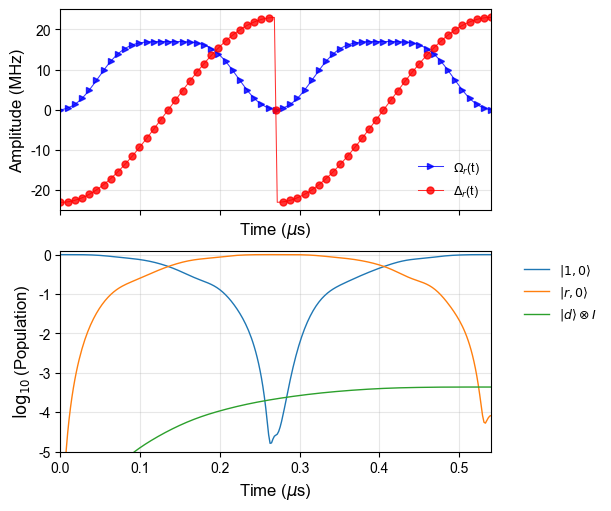

In [5]:
plotting_styles["Omega_r_pulse"]["markevery"] = 5
plotting_styles["Delta_r_pulse"]["markevery"] = 5
plt.rcParams.update(plt_config)

fig, axes = plt.subplots(2, 1, figsize=(6, 5), sharex=True, sharey=False, constrained_layout=True)
axes = axes.ravel()

# ============================================================================
# Plot the pulse shapes
# ============================================================================
pulse_dict = {
  'Omega_r': {'data': APR_pulse_Omega_r, 'args': Omega_r_pulse_args, 
              'label': r'$\Omega_r$(t)', 'style': 'Omega_r_pulse'},
  'Delta_r': {'data': APR_pulse_Delta_r, 'args': Delta_r_pulse_args, 
              'label': r'$\Delta_r$(t)', 'style': 'Delta_r_pulse'}
}

plot_pulse_shapes(
  ax = axes[0],
  tlist = tlist,
  pulse_dict = pulse_dict,
  title = None,
  xlabel = r"Time ($\mu$s)",
  ylabel = "Amplitude (MHz)",
  normalize_2pi = True,
  ylim = (-25, 25),
  grid_alpha = 0.3,
  legend_config = legend_styles['compact'],
)

# ============================================================================
# Plot the population evolution
# ============================================================================
pop_list = [result.expect[0], result.expect[1], result.expect[2]]
legend_list = [r"$|1,0\rangle$", r"$|r,0\rangle$", r"$|d\rangle\otimes I$"]
axes[1] = plot_population_evolution(
  ax = axes[1],
  tlist = tlist,
  pop_list = pop_list,
  legend_list = legend_list,
  log_scale = True,
  ylim = (-5, 0.1),
  plotting_style_list = [plotting_styles["pop_style_a"], 
                         plotting_styles["pop_style_a"], 
                         plotting_styles["pop_style_a"]],
)

#### Initial state & Monitered Operators

In [6]:
# initial state
psi0 = two_atom_fock_states[1][1]  # |1,1>

# list of wanted operators
state_1rr1 = 1 / np.sqrt(2) * (two_atom_fock_states[1][2] + two_atom_fock_states[2][1]) # |1,r> + |r,1> normalized
pop_stated = tensor(stated * stated.dag(), Qobj(np.eye(4)))  # |d><d| ⊗ I

expect_op_list = [
  psi0 * psi0.dag(),
  state_1rr1 * state_1rr1.dag(),
  two_atom_fock_states[2][2] * two_atom_fock_states[2][2].dag(),
  pop_stated,
]

#### Run the simulation

In [7]:
# construct the total Hamiltonian
Htotal, collapse_list = construct_TD_TAHam(atom0_ham_params, atom1_ham_params, 
                                           lindblad_params, lindblad_params, Rydberg_B)

# simulate the dynamics
result = mesolve(Htotal, psi0, tlist, collapse_list, expect_op_list, 
                 options={"store_final_state": 1, "store_states": 0})

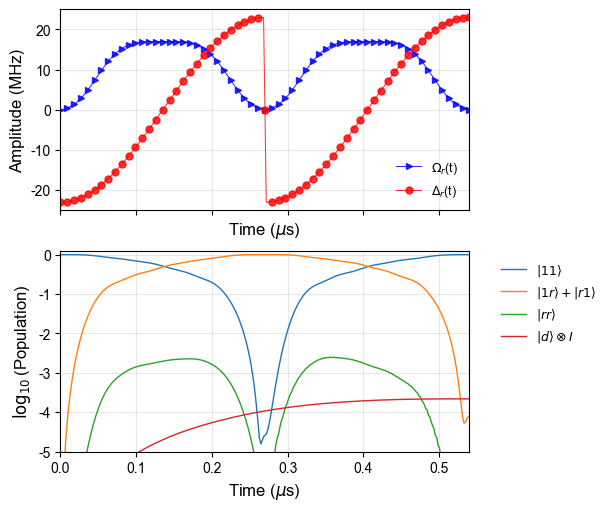

In [8]:
plt.rcParams.update(plt_config)
fig, axes = plt.subplots(2, 1, figsize=(6, 5), sharex=True, sharey=False, constrained_layout=True)
axes = axes.ravel()


# ============================================================================
# Plot the pulse shapes
# ============================================================================
pulse_dict = {
  'Omega_r': {'data': APR_pulse_Omega_r, 'args': Omega_r_pulse_args, 
              'label': r'$\Omega_r$(t)', 'style': 'Omega_r_pulse'},
  'Delta_r': {'data': APR_pulse_Delta_r, 'args': Delta_r_pulse_args, 
              'label': r'$\Delta_r$(t)', 'style': 'Delta_r_pulse'}
}

axes[0] = plot_pulse_shapes(
  ax = axes[0],
  tlist = tlist,
  pulse_dict = pulse_dict,
  title = None,
  xlabel = r"Time ($\mu$s)",
  ylabel = "Amplitude (MHz)",
  normalize_2pi = True,
  ylim = (-25, 25),
  grid_alpha = 0.3,
  legend_config = legend_styles['compact'],
)

# ============================================================================
# Plot the population evolution
# ============================================================================
pop_list = [result.expect[0], result.expect[1], result.expect[2], result.expect[3]]
legend_list = [r"$|11\rangle$", r"$|1r\rangle + |r1\rangle$", 
               r"$|rr\rangle$", r"$|d\rangle\otimes I$"]
axes[1] = plot_population_evolution(
  ax = axes[1],
  tlist = tlist,
  pop_list = pop_list,
  legend_list = legend_list,
  log_scale = True,
  ylim = (-5, 0.1),
  plotting_style_list = [plotting_styles["pop_style_a"]],
)

#### Observations: Rydberg State Population in CZ Gate

**Key Difference from X and Z Gates:**

Unlike single-qubit gates (X-gate and Z-gate) where populations in $|r\rangle$ and $|d\rangle$ states were negligible ($< 10^{-12}$), the CZ gate implementation using ARP protocol shows **significant transient population** in Rydberg and decay states:

1. **Non-negligible Rydberg excitation**: 
   - For initial state $|1,0\rangle$: Population in $|r,0\rangle$ reaches $\sim 10^{-4}$
   - For initial state $|1,1\rangle$: Symmetric state $(|1,r\rangle + |r,1\rangle)/\sqrt{2}$ shows similar population levels
   - This is **essential** for the ARP mechanism to work

2. **Decay channel leakage**:
   - Population in $|d\rangle \otimes I$ states is also significant ($\sim 10^{-3}$ to $10^{-4}$)
   - This represents a non-negligible error channel

**Physical Explanation:**

- **X/Z gates**: Used direct drive on computational basis ($\Omega_{01}$, $\delta_1$) with $\Omega_r = 0, \Delta_r = 0$
  - No mechanism to populate $|r\rangle$ → minimal leakage
  
- **CZ gate**: Requires Rydberg excitation ($\Omega_{1r} \neq 0, \Delta_r \neq 0$) to utilize Rydberg blockade
  - System must transiently populate $|r\rangle$ states
  - Blockade interaction $B$ only affects doubly-excited state $|r,r\rangle$
  - During the ARP process, single-atom Rydberg states are significantly populated
  - Spontaneous emission $\gamma_r$ causes leakage to $|d\rangle$ during this process

**Implications:**
- Rydberg state lifetime directly impacts CZ gate fidelity
- Leakage is an intrinsic error channel that cannot be eliminated, only minimized
- This explains why CZ gate fidelity is more sensitive to $\gamma_r$ than single-qubit gates

## Task 2: Fidelity Analysis vs Rydberg State Lifetime

Since ARP protocol requires transient population in $|r\rangle$ states (unlike X/Z gates), spontaneous emission becomes a significant error channel. The error scales with: (Rydberg population) × (gate time) × $\gamma_r$.

**Goal: Physical Mechanism:**

Investigate how spontaneous emission from the Rydberg state affects CZ gate fidelity.

- Leakage to $|d\rangle$ state decreases with longer lifetime

**Strategy:**- Beyond certain lifetime ($\sim 540\mu s$), fidelity saturates (limited by other error sources)

- Fix pulse parameters at reference values: $T = 0.54\mu s$, $\Omega_{1r}/2\pi = 17$ MHz, $\Delta_r/2\pi = 23$ MHz, $B/2\pi = 200$ MHz- Longer Rydberg lifetime (smaller $\gamma_r$) → Higher fidelity

- Scan Rydberg decay rate: $\gamma_r \in \{1/5, 1/50, 1/100, 1/250, 1/540, 1/1000\}$ μs⁻¹**Expected Observations:**

- Calculate gate fidelity using mixed state fidelity (average over computational basis initial states)
- Compare three fidelity metrics: arithmetic, geometric, and mixed

#### Initialize

In [9]:
%reset
%reload_ext autoreload
%autoreload 2

# Import ALL configuration variables from config file
from Default_TQCONFIG_for_CZ_GATE import *

In [10]:
# decay rate list for scans
gamma_r_list = [1/5, 1/50, 1/100, 1/250, 1/540, 1/1000]

# initial state list for gate fidelity computation
psi0_list = make_initial_list_for_gate_fidelity(num_qubits = 2, dim_atom = 4)
qs0_list = make_initial_list_for_gate_fidelity(num_qubits = 2, dim_atom = 2)

In [11]:
# store fidelity results
fidelity_arith_list = []
fidelity_geom_list = []
fidelity_mixed_list = []

for pidx, gamma_r in enumerate(gamma_r_list):
  # update the Lindblad parameters
  lindblad_params['gamma_r'] = gamma_r  # [1/us]

  # construct Hamiltonian
  Htotal, collapse_list = construct_TD_TAHam(atom0_ham_params, atom1_ham_params, 
                                             lindblad_params, lindblad_params, Rydberg_B)
  
  # compute the state fidelities
  state_fidelity_list, _ = compute_state_fidelity(
    qs0_list,
    target_gate, 
    Htotal, 
    collapse_list, 
    tlist,
    psi0_list=psi0_list,
    comp_indices=comp_indices,
    expect_list=None
  )

  # compute different types of gate fidelities
  fidelity_mixed, fidelity_geom, fidelity_arith = compute_gate_fidelity_mixed(
    state_fidelity_list, dim_qubits, True
  )
  fidelity_mixed_list.append(fidelity_mixed)
  fidelity_geom_list.append(fidelity_geom)
  fidelity_arith_list.append(fidelity_arith)

d:\anaconda3\envs\my_qiskit\Lib\site-packages\qutip\core\data\expm.py:139: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  return Dense(scipy.linalg.sqrtm(matrix.as_ndarray()))


<>:16: SyntaxWarning: invalid escape sequence '\g'
<>:16: SyntaxWarning: invalid escape sequence '\g'
C:\Windows\Temp\ipykernel_21184\1193913223.py:16: SyntaxWarning: invalid escape sequence '\g'
  title = "CZ Gate Infidelity vs Lifetime of Rydberg State $\gamma_r$ ( B/2$\pi$ = 200 MHz )",


<Axes: title={'center': 'CZ Gate Infidelity vs Lifetime of Rydberg State $\\gamma_r$ ( B/2$\\pi$ = 200 MHz )'}, xlabel='$\\log_{10}(\\gamma_r*540)$ (MHz)', ylabel='1-F'>

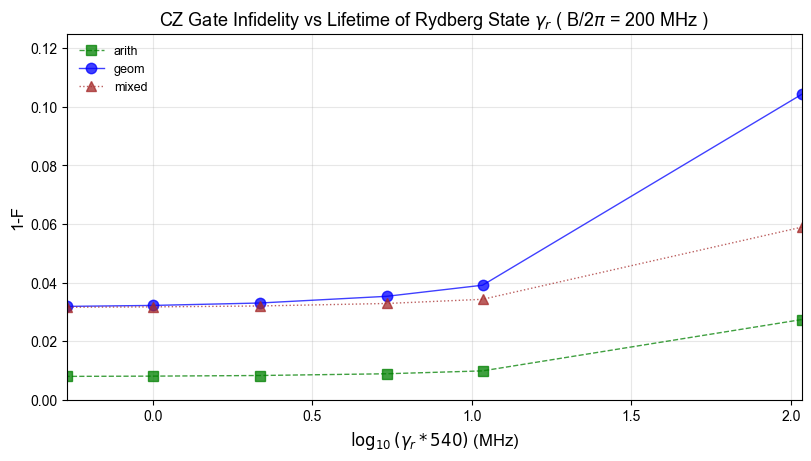

In [12]:
legend_list = ['arith', 'geom', 'mixed']

# plot
plt.rcParams.update(plt_config)

fig, ax = plt.subplots(figsize=(8, 4.5), sharex=True, sharey=True, constrained_layout=True)

plot_fidelity_vs_parameter(
    ax = ax,
    param_list = np.log10(np.array(gamma_r_list) * 540),
    # fidelity_list = [fidelity_arith_results],
    # fidelity_list = [fidelity_geom_results],
    # fidelity_list = [fidelity_mixed_results],
    fidelity_list = [fidelity_arith_list, fidelity_geom_list, fidelity_mixed_list],
    legend_list = legend_list,
    title = "CZ Gate Infidelity vs Lifetime of Rydberg State $\gamma_r$ ( B/2$\pi$ = 200 MHz )",
    xlabel = r"$\log_{10}(\gamma_r*540)$ (MHz)",
    ylabel = "1-F",
    use_infidelity = True,
    log_scale = False,
    xlim = None,
    ylim = (0, 0.125),
    grid_alpha = 0.3,
    show_legend = True,
    plotting_style_list = [plotting_styles['fidelity_style_a'], 
                           plotting_styles['fidelity_style_b'], 
                           plotting_styles['fidelity_style_c']]
)

### Observations: CZ Gate Fidelity vs Rydberg Lifetime

**Key Findings:**

1. **Strong lifetime dependence**: Gate fidelity increases significantly as $\gamma_r$ decreases (longer Rydberg lifetime)
   - At $\gamma_r = 1/(5\mu s)$ (short lifetime): Infidelity $\sim 12\%$
   - At $\gamma_r = 1/(540\mu s)$ (typical): Infidelity $\sim 2-3\%$
   - At $\gamma_r = 1/(1000\mu s)$ (long lifetime): Infidelity $\sim 1.5-2\%$

2. **Fidelity saturation**: Below $\gamma_r \approx 1/(540\mu s)$, further increasing lifetime provides diminishing returns
   - Infidelity reduction becomes marginal
   - Other error sources start to dominate

3. **Error budget analysis**:
   - **Short lifetime regime** ($\gamma_r > 1/100$ μs⁻¹): Spontaneous emission is the dominant error
   - **Long lifetime regime** ($\gamma_r < 1/540$ μs⁻¹): Residual errors from pulse imperfections, non-adiabatic transitions, and other systematic effects

**Physical Interpretation:**

The ARP protocol requires transient population in Rydberg states $|r\rangle$ during gate operation (as shown in previous population dynamics). During this time:
- Spontaneous emission from $|r\rangle$ causes leakage to decay state $|d\rangle$ at rate $\gamma_r$
- Leakage : the total population of $|r\rangle$

**Comparison with Single-Qubit Gates:**
- X/Z gates: Minimal Rydberg population → almost insensitive to $\gamma_r$
- CZ gate: Significant Rydberg population → strong $\gamma_r$ dependence

**Saturation Mechanism:**
Beyond $\gamma_r \sim 1/(540\mu s)$, the remaining infidelity is limited by:
- Finite gate time $T = 0.54\mu s$ (non-adiabatic transitions)
- Finite Rydberg blockade strength $B = 200$ MHz
- Numerical discretization errors

### `Task 3: Parameter Scaling and Rydberg Blockade Strength Scan`

- Approximate scaling: $\Omega_r \propto 1/T$, $\Delta_r \propto 1/T$ (faster gates need stronger drives)

**Goal:** - Pulse shape ratio: $\tau = 0.175T$

Investigate how CZ gate fidelity depends on Rydberg blockade strength $B$ for different pulse parameter sets.All three parameter sets maintain:

**Parameter Scaling:**

**Pulse Parameter Sets:**

Test three scaled parameter configurations:

1. **Slow gate**: $T = 1.08\mu s$, $\Omega_{1r}/2\pi = 8.5$ MHz, $\Delta_r/2\pi = 11.5$ MHz

2. **Reference**: $T = 0.54\mu s$, $\Omega_{1r}/2\pi = 17$ MHz, $\Delta_r/2\pi = 23$ MHz (Ref. [3])
3. **Fast gate**: $T = 0.27\mu s$, $\Omega_{1r}/2\pi = 34$ MHz, $\Delta_r/2\pi = 46$ MHz

**Expected Observations:**

**Blockade Strength Scan:**

- $B/2\pi \in \{0, 50, 100, 200, 300, ..., 1000, 1250, 1500, 1750, 2000, 2500, 3000\}$ MHz- Use fixed Rydberg lifetime $\gamma_r = 1/(540\mu s)$
- For each $(T, \Omega_r, \Delta_r, B)$ combination, calculate CZ gate fidelity

#### Initialize

In [13]:
%reset
%reload_ext autoreload
%autoreload 2

# Import ALL configuration variables from config file
from Default_TQCONFIG_for_CZ_GATE import *

In [14]:
# pulse parameter lists for scans
T_gate_list = [1.08, 0.54, 0.27] # [us] 
tau_list = [0.175 * T_gate for T_gate in T_gate_list]  # [us]
amp_Omega_r_list = [8.5*2*np.pi, 17*2*np.pi, 34*2*np.pi]  # [MHz]
amp_Delta_r_list = [11.5*2*np.pi, 23*2*np.pi, 46*2*np.pi]  # [MHz]

# Rydberg interaction strength list for scans
scale_B_list = [0, 50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000,
                1250, 1500, 1750, 2000, 2500, 3000]  # [MHz]
# scale_B_list = [0, 50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]  # [MHz]
Rydberg_B_list = [scale_B * 2 * np.pi for scale_B in scale_B_list]

In [15]:
# initial state list for gate fidelity computation
psi0_list = make_initial_list_for_gate_fidelity(num_qubits = 2, dim_atom = 4)
qs0_list = make_initial_list_for_gate_fidelity(num_qubits = 2, dim_atom = 2)

In [ ]:
# store fidelity results
fidelity_arith_results = []
fidelity_geom_results = []
fidelity_mixed_results = []

# for each set of pulse parameters
for pidx, (T_gate, tau, amp_Omega_r, amp_Delta_r) in enumerate(zip(T_gate_list, tau_list, amp_Omega_r_list, amp_Delta_r_list)):
  # update pulse args
  Omega_r_pulse_args["amp_Omega_r"] = amp_Omega_r
  Omega_r_pulse_args["T_gate"] = T_gate
  Omega_r_pulse_args["tau"] = tau
  Delta_r_pulse_args["amp_Delta_r"] = amp_Delta_r
  Delta_r_pulse_args["T_gate"] = T_gate
  Delta_r_pulse_args["tau"] = tau
  
  # time list
  tlist = np.linspace(0, T_gate, 300 + 1)  # [us]

  # store fidelity for this pulse
  fidelity_arith_for_this_pulse = []
  fidelity_geom_for_this_pulse = []
  fidelity_mixed_for_this_pulse = []

  # for each Rydberg blockade strength
  for rIdx, Rydberg_B in enumerate(Rydberg_B_list):
    # construct the total Hamiltonian
    Htotal, collapse_list = construct_TD_TAHam(
      atom0_ham_params, atom1_ham_params, 
      lindblad_params, lindblad_params, Rydberg_B)
    
    # compute the state fidelities
    state_fidelity_list, _ = compute_state_fidelity(
      qs0_list,
      target_gate, 
      Htotal, 
      collapse_list, 
      tlist,
      psi0_list=psi0_list,
      comp_indices=comp_indices,
      expect_list=None
    )

    # compute different types of gate fidelities
    fidelity_mixed, fidelity_geom, fidelity_arith = compute_gate_fidelity_mixed(
      state_fidelity_list, dim_qubits, True)
    fidelity_mixed_for_this_pulse.append(fidelity_mixed)
    fidelity_geom_for_this_pulse.append(fidelity_geom)
    fidelity_arith_for_this_pulse.append(fidelity_arith)
  
  # store the results for this pulse
  fidelity_arith_results.append(fidelity_arith_for_this_pulse)
  fidelity_geom_results.append(fidelity_geom_for_this_pulse)
  fidelity_mixed_results.append(fidelity_mixed_for_this_pulse)

<Axes: title={'center': 'CZ Gate Infidelity vs Rydberg Blockade Strength'}, xlabel='$B/2\\pi$ (MHz)', ylabel='Infidelity'>

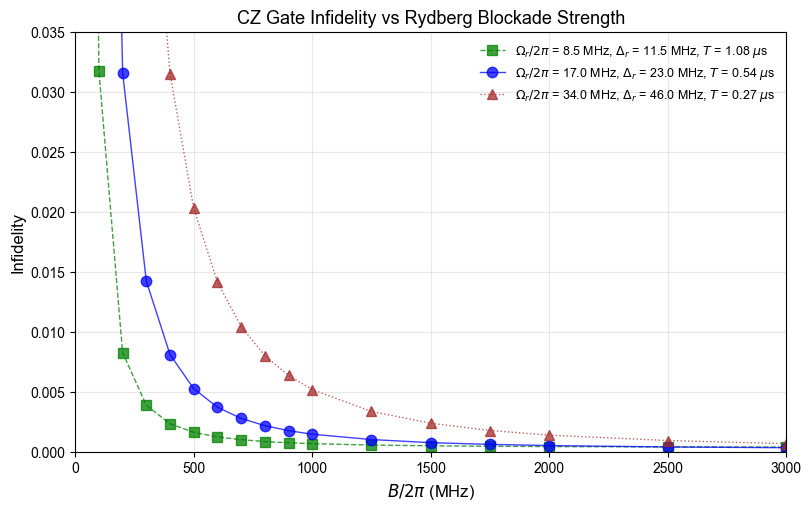

In [ ]:
legend_list = [r'$\Omega_r/2\pi$ = {:.1f} MHz, $\Delta_r$ = {:.1f} MHz, $T$ = {:.2f} $\mu$s'.
               format(amp_Omega_r/(2*np.pi), amp_Delta_r/(2*np.pi), T_gate) 
               for amp_Omega_r, amp_Delta_r, T_gate 
               in zip(amp_Omega_r_list, amp_Delta_r_list, T_gate_list)]

# plot
plt.rcParams.update(plt_config)

fig, ax = plt.subplots(figsize=(8, 5), sharex=True, sharey=True, constrained_layout=True)

plot_fidelity_vs_parameter(
    ax = ax,
    param_list = scale_B_list,
    # fidelity_list = fidelity_arith_results,
    # fidelity_list = fidelity_geom_results,
    fidelity_list = fidelity_mixed_results,
    legend_list = legend_list,
    title = "CZ Gate Infidelity vs Rydberg Blockade Strength",
    xlabel = r"$B/2\pi$ (MHz)",
    ylabel = "Infidelity",
    use_infidelity = True,
    log_scale = False,
    xlim = None,
    ylim = (0, 0.035),
    grid_alpha = 0.3,
    show_legend = True,
    plotting_style_list = [plotting_styles['fidelity_style_a'], 
                           plotting_styles['fidelity_style_b'], 
                           plotting_styles['fidelity_style_c']]
)

### Observations: CZ Gate Fidelity vs Rydberg Blockade Strength

**Key Findings:**

1. **Blockade strength scaling**: Gate fidelity increases monotonically with $B$ until saturation3. Balance gate speed against required blockade strength and hardware constraints

   - At $B = 0$: High infidelity (~3%) due to lack of blockade2. Scale $\Omega_r$ and $\Delta_r$ inversely with $T$ to maintain adiabaticity

   - At $B \sim 200$ MHz: Near-optimal fidelity achieved.

   - At $B > 500$ MHz: Fidelity saturates (infidelity ~1-2%)


2. **Residual infidelity**: Even at very large $B$, a small residual error remains (~1-2%)- Residual infidelity levels comparable to reported values

3. **General Behavior**:  All three fidelity metrics (arithmetic, geometric, mixed) show similar behavior

**Physical Interpretation:**- Optimal $B$ values consistent with theoretical predictions

- Qualitative trends match the reference paper